MOD10: Machine learning 

Fall 2025 

Instructor: Mohammed A. Shehab

Machine learning project information (30%)

In [167]:
! pip install kagglehub


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [197]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
import kagglehub
from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.svm import SVC

# 1. Data Preprocessing and EDA

## Load and clean dataset

Load and clean the dataset, handling missing values, normalizing or scaling 
numerical features, and encoding categorical variables. 

In [169]:
# Download latest version
path = kagglehub.dataset_download("chethuhn/network-intrusion-dataset")
print("Path to dataset files:", path)

Path to dataset files: C:\Users\arthu\.cache\kagglehub\datasets\chethuhn\network-intrusion-dataset\versions\1


In [170]:
# see list of downloaded dataset files
list_of_files = os.listdir(path)
print("Files in dataset:", list_of_files)

Files in dataset: ['Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv', 'Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv', 'Friday-WorkingHours-Morning.pcap_ISCX.csv', 'Monday-WorkingHours.pcap_ISCX.csv', 'Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv', 'Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv', 'Tuesday-WorkingHours.pcap_ISCX.csv', 'Wednesday-workingHours.pcap_ISCX.csv']


In [171]:
# Load first dataset
df = pd.read_csv(f"{path}/{list_of_files[0]}")
df.head()

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,54865,3,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,55054,109,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,55055,52,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,46236,34,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,54863,3,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


We concatenate all datasets because they have the same columns and represent different days of the same measurements.

In [172]:
# concatenate all dataset files
dataframes = []
for i, file in enumerate(list_of_files):
    df_part = pd.read_csv(f"{path}/{file}")
    df_part['source_file'] = i  # optional: add a column to identify source file
    dataframes.append(df_part)

# concatenate all dataframes into a single dataframe
df = pd.concat(dataframes, axis=0, ignore_index=True)
print("Combined dataset shape:", df.shape)
df.head()

Combined dataset shape: (2830743, 80)


,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label,source_file
0,54865,3,2,0,12,0,6,6,6.0,0.0,...,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN,0
1,55054,109,1,1,6,6,6,6,6.0,0.0,...,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN,0
2,55055,52,1,1,6,6,6,6,6.0,0.0,...,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN,0
3,46236,34,1,1,6,6,6,6,6.0,0.0,...,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN,0
4,54863,3,2,0,12,0,6,6,6.0,0.0,...,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN,0


In [173]:
# define test mode, to work with a smaller subset during development, instead of 2.8M rows
TEST_MODE = True
if TEST_MODE:
    df = df.sample(n=50000, random_state=42)
    print("Test mode: using smaller dataset shape:", df.shape)

Test mode: using smaller dataset shape: (50000, 80)


Let's take a look at all the columns in the dataset.

In [174]:
# print the first lines with all columns
pd.set_option('display.max_columns', None)
print(df.head())
pd.set_option('display.max_columns', 20)  # reset to default

          Destination Port   Flow Duration   Total Fwd Packets  \
746827               50545             232                   1   
946912                  53           31226                   2   
2216843                 80        99951883                   9   
699389                  53           30894                   4   
1170268                 53           48943                   2   

          Total Backward Packets  Total Length of Fwd Packets  \
746827                         1                            0   
946912                         2                           68   
2216843                        7                          317   
699389                         2                          140   
1170268                        2                           88   

          Total Length of Bwd Packets   Fwd Packet Length Max  \
746827                              0                       0   
946912                            380                      34   
2216843          

In [175]:
df[' Label'].unique()

array(['BENIGN', 'DoS Hulk', 'DDoS', 'PortScan', 'DoS slowloris',
       'DoS GoldenEye', 'FTP-Patator', 'DoS Slowhttptest', 'Bot',
       'SSH-Patator', 'Web Attack � Brute Force', 'Web Attack � XSS'],
      dtype=object)

This is the label column we will predict. It contains a lot of different values. Benign values are labeled as "BENIGN", while attacks have different labels. We want to predict if there is an attack or not, but also which type of attack it is. So we will keep the original labels for multi-class classification.

In [176]:
# view some basic info about the dataset
print("\nDataset Info:")
print(df.info())

print("\nMissing Values per Column:")
print(df.isnull().sum())
print(f"Total number of missing values: {df.isnull().sum().sum()}")

print("\nBasic Statistics:")
display(df.describe(include='all'))


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
Index: 50000 entries, 746827 to 2337454
Data columns (total 80 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0    Destination Port             50000 non-null  int64  
 1    Flow Duration                50000 non-null  int64  
 2    Total Fwd Packets            50000 non-null  int64  
 3    Total Backward Packets       50000 non-null  int64  
 4   Total Length of Fwd Packets   50000 non-null  int64  
 5    Total Length of Bwd Packets  50000 non-null  int64  
 6    Fwd Packet Length Max        50000 non-null  int64  
 7    Fwd Packet Length Min        50000 non-null  int64  
 8    Fwd Packet Length Mean       50000 non-null  float64
 9    Fwd Packet Length Std        50000 non-null  float64
 10  Bwd Packet Length Max         50000 non-null  int64  
 11   Bwd Packet Length Min        50000 non-null  int64  
 12   Bwd Packet Length Mean       50000 non-nul

c:\Users\arthu\OneDrive\Efrei\I1\S5\MachineLearning\machineLearningCybersecurity\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
c:\Users\arthu\OneDrive\Efrei\I1\S5\MachineLearning\machineLearningCybersecurity\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label,source_file
count,50000.000000,5.000000e+04,50000.000000,50000.000000,50000.000000,5.000000e+04,50000.000000,50000.000000,50000.000000,50000.000000,...,5.000000e+04,5.000000e+04,5.000000e+04,5.000000e+04,5.000000e+04,5.000000e+04,5.000000e+04,5.000000e+04,50000,50000.000000
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BENIGN,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40193,NaN
mean,8122.670040,1.467833e+07,6.404040,6.329980,518.673680,6.986600e+03,207.416480,18.604720,58.313406,68.733582,...,7.749996e+04,4.327377e+04,1.535587e+05,5.316534e+04,8.217208e+06,4.902213e+05,8.587389e+06,7.830262e+06,NaN,4.156480
std,18355.671208,3.356638e+07,63.476262,76.536092,2723.044996,1.650067e+05,707.720042,57.708775,186.253930,277.492447,...,5.408293e+05,4.194620e+05,1.012230e+06,4.593371e+05,2.350088e+07,4.552573e+06,2.422544e+07,2.323902e+07,NaN,2.348877
min,0.000000,-1.000000e+00,1.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,NaN,0.000000
25%,53.000000,1.540000e+02,2.000000,1.000000,12.000000,4.000000e+00,6.000000,0.000000,6.000000,0.000000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,NaN,2.000000
50%,80.000000,3.128800e+04,2.000000,2.000000,62.000000,1.230000e+02,37.000000,2.000000,34.000000,0.000000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,NaN,4.000000
75%,443.000000,2.935594e+06,5.000000,4.000000,193.000000,4.840000e+02,85.000000,36.000000,50.000000,26.162951,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,NaN,6.000000


In [177]:
# remove columns with the same value for all rows
for col in df.columns:
    if df[col].nunique() == 1:
        df.drop(columns=[col], inplace=True)
        print(f"Dropped column {col} with a single unique value.")

Dropped column  Bwd PSH Flags with a single unique value.
Dropped column  Bwd URG Flags with a single unique value.
Dropped column Fwd Avg Bytes/Bulk with a single unique value.
Dropped column  Fwd Avg Packets/Bulk with a single unique value.
Dropped column  Fwd Avg Bulk Rate with a single unique value.
Dropped column  Bwd Avg Bytes/Bulk with a single unique value.
Dropped column  Bwd Avg Packets/Bulk with a single unique value.
Dropped column Bwd Avg Bulk Rate with a single unique value.


In [178]:
numeric_cols = df.select_dtypes(include=np.number).columns
print("\nNumber of numeric Columns:", len(numeric_cols))

categorical_cols = df.select_dtypes(include=['object']).columns
print("\nCategorical Columns:", list(categorical_cols))


Number of numeric Columns: 71

Categorical Columns: [' Label']


In [179]:
df[' PSH Flag Count'].unique()

array([0, 1])

Some columns contain integers, but are actually binary values 0 or 1. We will encode them as categorical variables.

In [180]:
# add columns containing only 0 and 1 to categorical columns
binary_cols = [col for col in numeric_cols if df[col].nunique() == 2]
print("\nBinary Columns (0/1):", binary_cols)
categorical_cols = binary_cols + ['source_file'] + categorical_cols.tolist() 
print("\nUpdated number of Categorical Columns:", len(categorical_cols))
numeric_cols = [col for col in numeric_cols if col not in binary_cols]
print("\nUpdated number of Numeric Columns:", len(numeric_cols))


Binary Columns (0/1): ['Fwd PSH Flags', ' Fwd URG Flags', 'FIN Flag Count', ' SYN Flag Count', ' RST Flag Count', ' PSH Flag Count', ' ACK Flag Count', ' URG Flag Count', ' CWE Flag Count', ' ECE Flag Count']

Updated number of Categorical Columns: 12

Updated number of Numeric Columns: 61


### Handling missing values

In [181]:
# Handle infinite or very large values before scaling
print(f"Number of infinite values before cleaning: {np.isinf(df[numeric_cols]).sum().sum()}")
df[numeric_cols] = df[numeric_cols].replace([np.inf, -np.inf], np.nan)


# Fill remaining missing values
for col in df.columns:
    if df[col].dtype == 'object':
        # categorical column, fill with most frequent value
        df[col] = df[col].fillna(df[col].mode()[0])
    else:
        # numerical column, fill with median value
        df[col] = df[col].fillna(df[col].median())

Number of infinite values before cleaning: 83


### Normalizing or scaling numerical features

In [182]:
# Clip extremely large values to avoid numerical overflow
df[numeric_cols] = df[numeric_cols].clip(lower=-1e10, upper=1e10)

scaler = StandardScaler()  # to get mean = 0, std = 1
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

a posteriori : ecrire une petite phrase pour expliquer pk on a normalisé et pas rescalé.

### Encoding categorical variables

In [183]:
le = LabelEncoder()
for col in categorical_cols:
    df[col] = le.fit_transform(df[col].astype(str))
    print(f"Encoded {col} with classes: {le.classes_}")

Encoded Fwd PSH Flags with classes: ['0' '1']
Encoded  Fwd URG Flags with classes: ['0' '1']
Encoded FIN Flag Count with classes: ['0' '1']
Encoded  SYN Flag Count with classes: ['0' '1']
Encoded  RST Flag Count with classes: ['0' '1']
Encoded  PSH Flag Count with classes: ['0' '1']
Encoded  ACK Flag Count with classes: ['0' '1']
Encoded  URG Flag Count with classes: ['0' '1']
Encoded  CWE Flag Count with classes: ['0' '1']
Encoded  ECE Flag Count with classes: ['0' '1']
Encoded source_file with classes: ['-0.0666197284514735' '-0.49235930188880367' '-0.9180988753261339'
 '-1.343838448763464' '-1.7695780222007942' '0.3591198449858567'
 '0.7848594184231868' '1.2105989918605171']
Encoded  Label with classes: ['BENIGN' 'Bot' 'DDoS' 'DoS GoldenEye' 'DoS Hulk' 'DoS Slowhttptest'
 'DoS slowloris' 'FTP-Patator' 'PortScan' 'SSH-Patator'
 'Web Attack � Brute Force' 'Web Attack � XSS']


## EDA - Exploratory Data Analysis

Conduct EDA, visualizing feature distributions and identifying potential 
relationships to guide feature engineering. 

### Visualize distibution of target variable

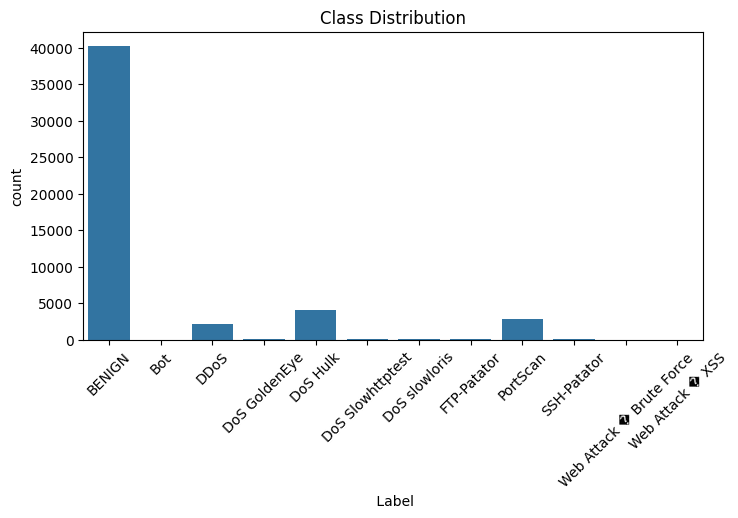

In [184]:
target_col = ' Label'
plt.figure(figsize=(8, 4))
sns.countplot(x=df[target_col])
plt.title("Class Distribution")
class_names = le.inverse_transform(sorted(df[target_col].unique()))
plt.xticks(ticks=range(len(class_names)), labels=class_names, rotation=45)
plt.show()

Begnign is the most frequent class. Frequent attacks are DDoS, DoS Hulk and PortScan.

### Visualize feature distributions

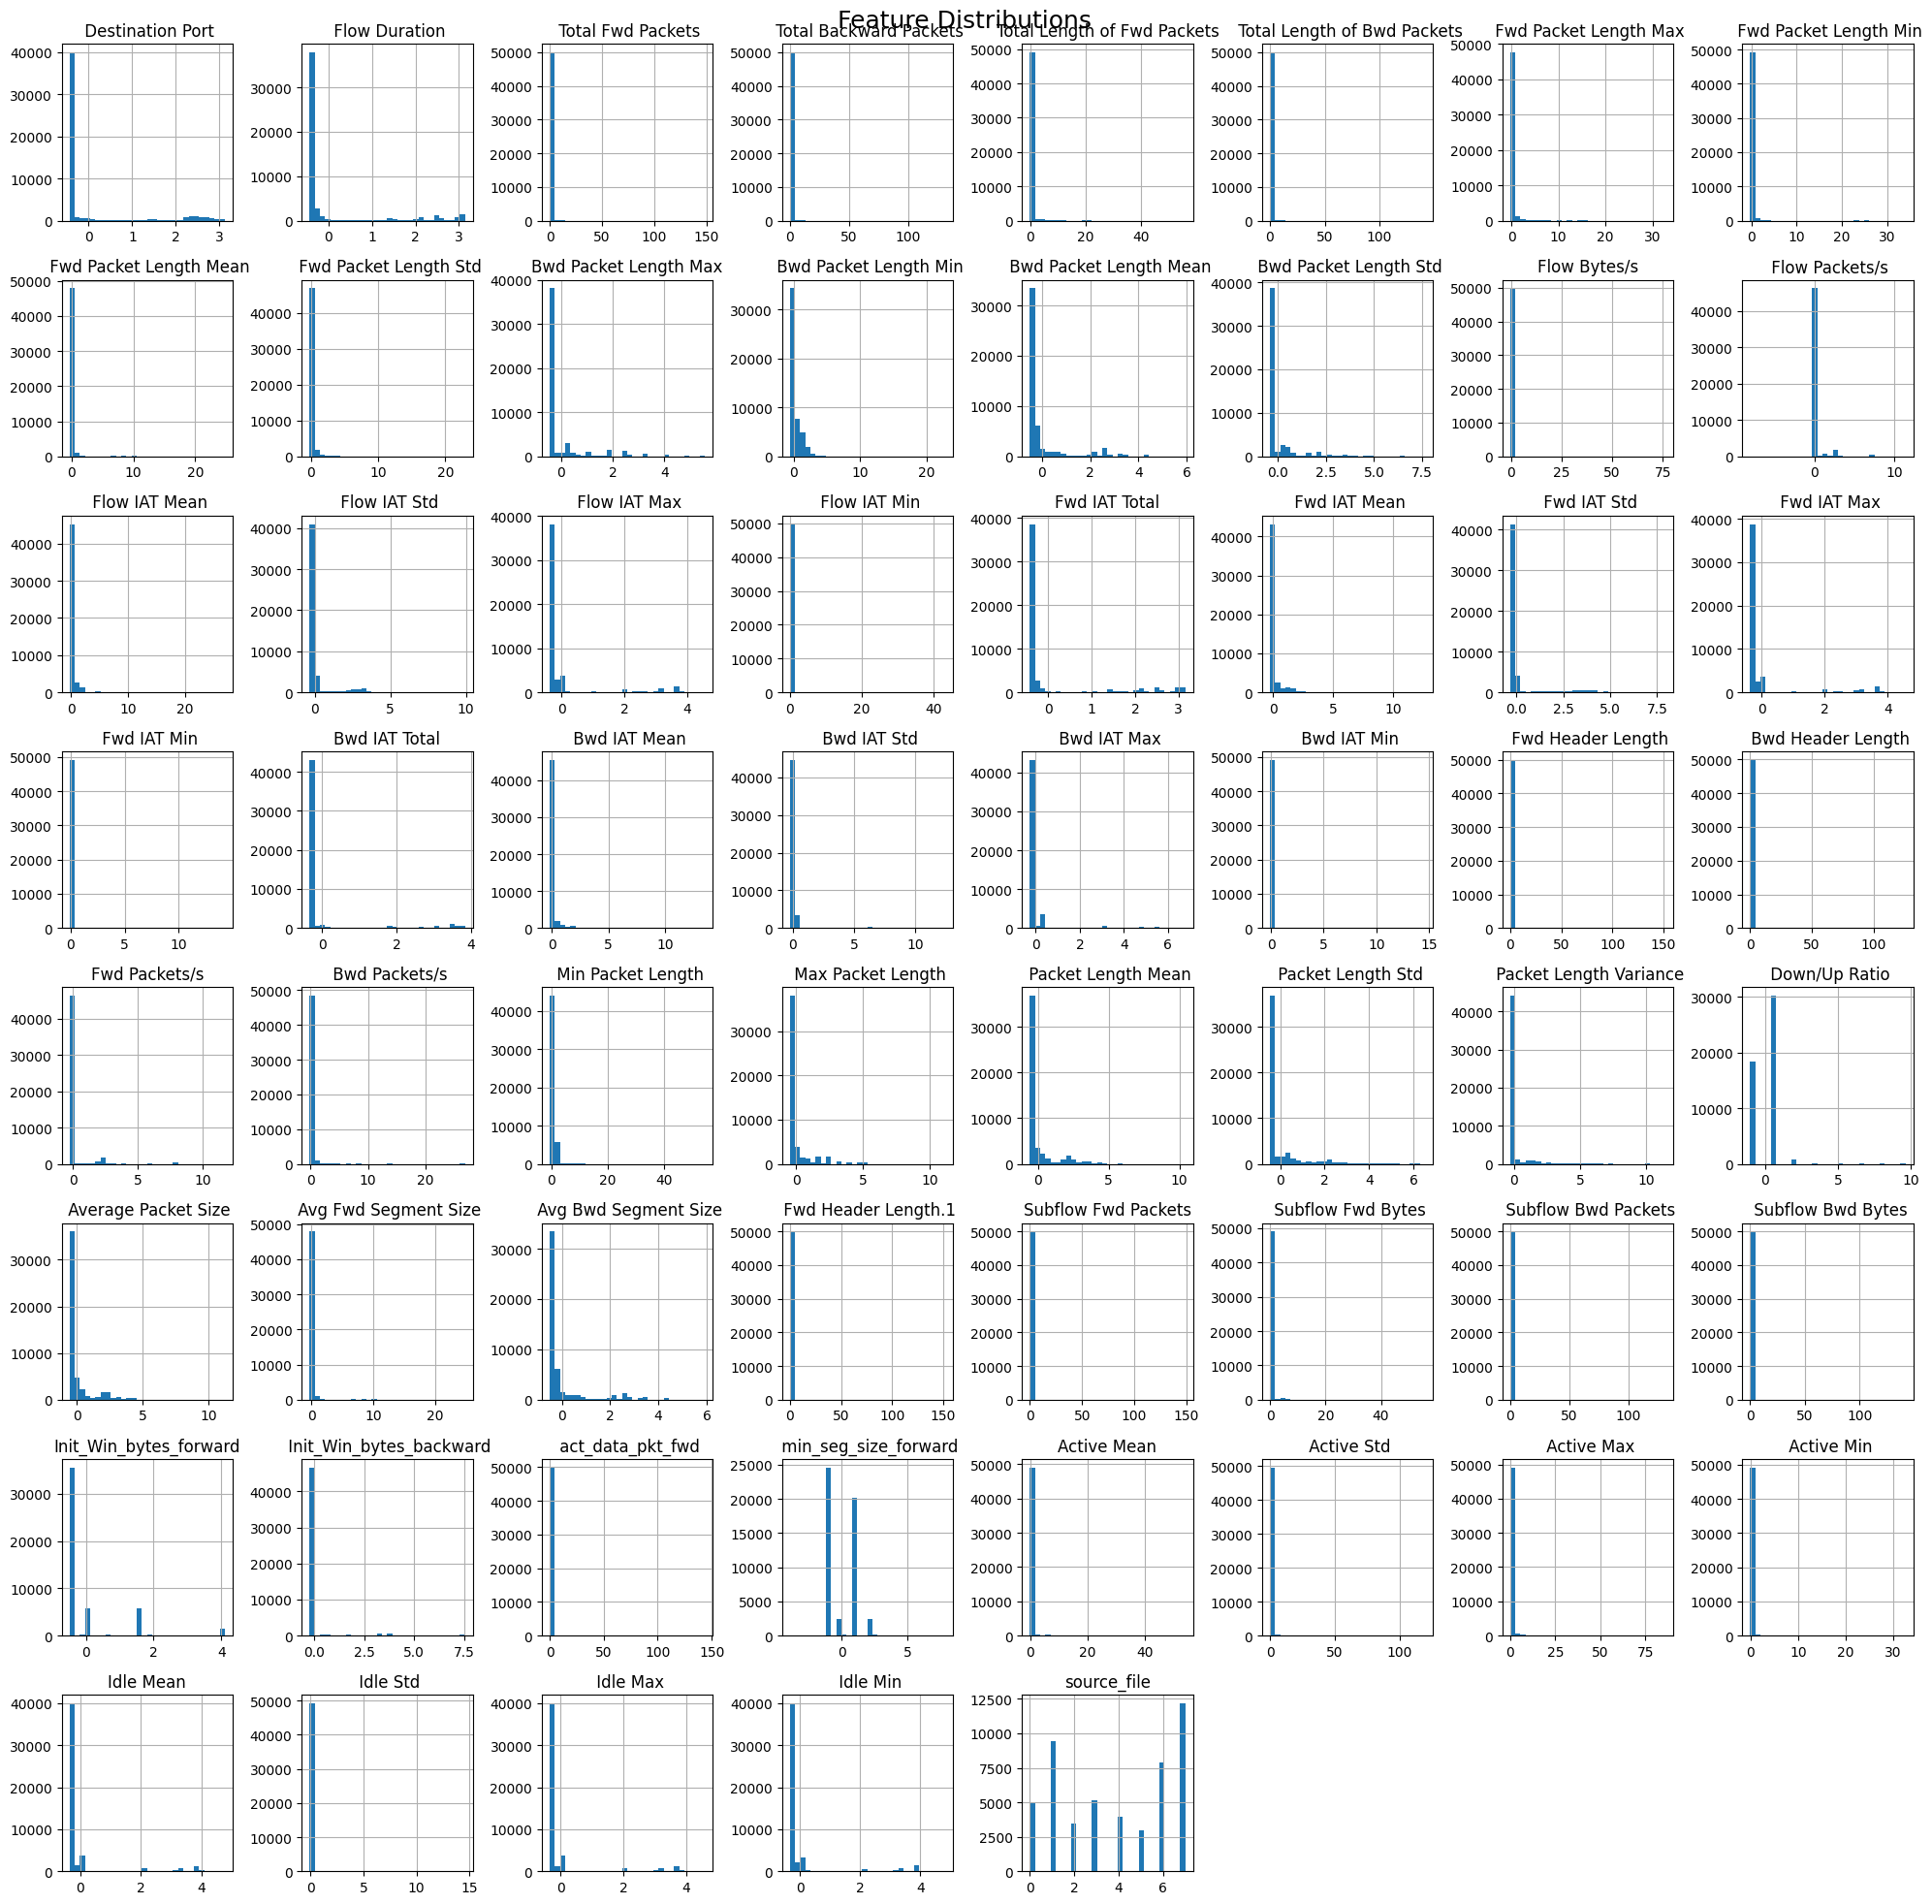

In [185]:
df[numeric_cols].hist(bins=30, figsize=(20, 20))
plt.suptitle("Feature Distributions", fontsize=18)
plt.tight_layout()
plt.show()

La tu peux aller plus loin en regardant features par features, mais c'est deja pas mal.

### Correlation analysis

          Destination Port   Flow Duration   Total Fwd Packets  \
746827            2.311152       -0.437290           -0.085136   
946912           -0.439633       -0.436367           -0.069382   
2216843          -0.438162        2.540471            0.040897   
699389           -0.439633       -0.436376           -0.037873   
1170268          -0.439633       -0.435839           -0.069382   

          Total Backward Packets  Total Length of Fwd Packets  \
746827                 -0.069641                    -0.190478   
946912                 -0.056575                    -0.165505   
2216843                 0.008754                    -0.074063   
699389                 -0.056575                    -0.139064   
1170268                -0.056575                    -0.158160   

          Fwd Packet Length Max   Fwd Packet Length Min  \
746827                -0.293080               -0.322393   
946912                -0.245038                0.266778   
2216843                0.154842    

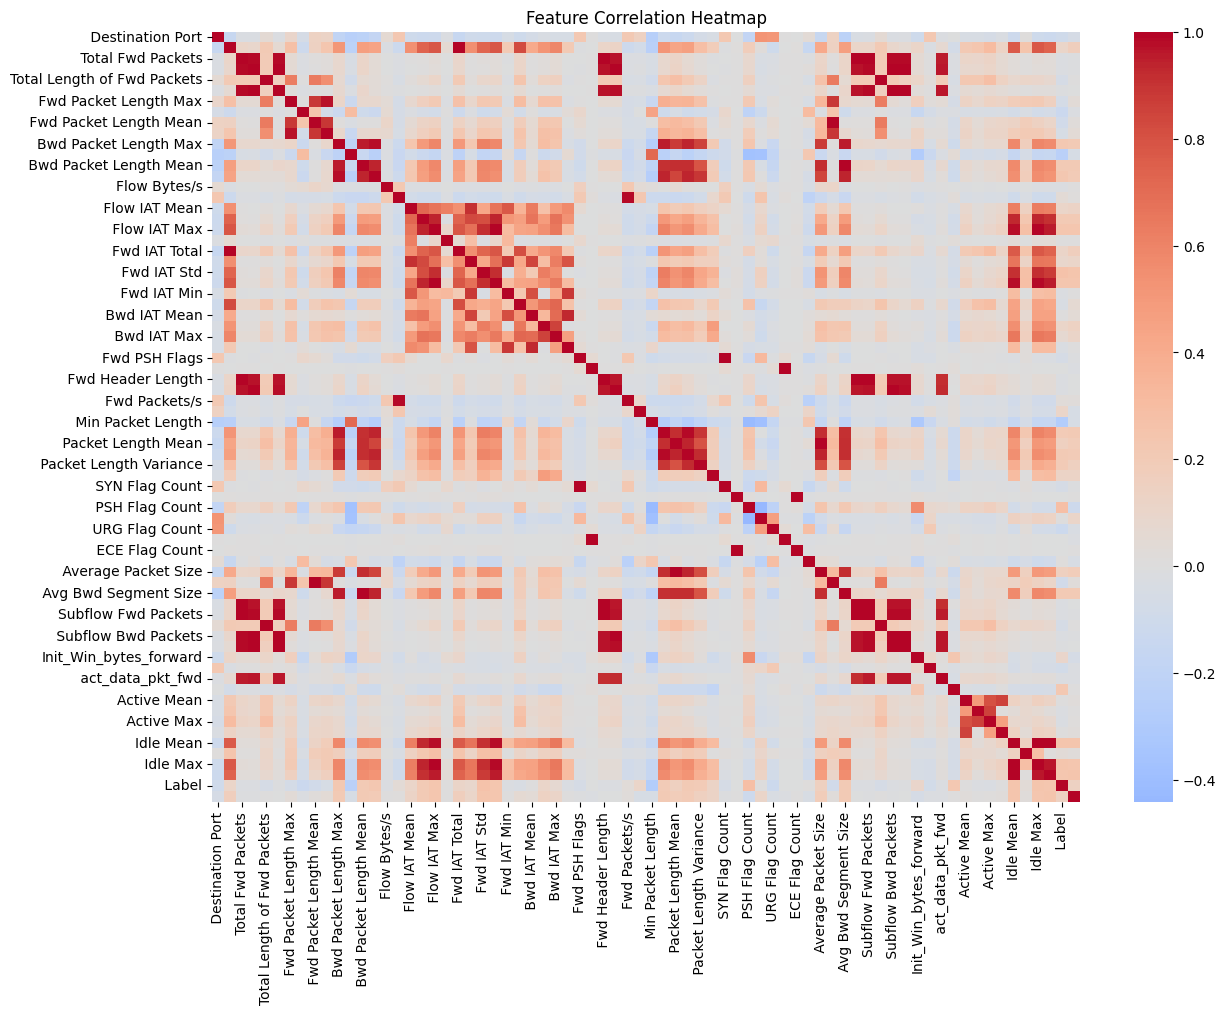

Class répartition before SMOTE :
 Label
0     40193
4      4079
8      2830
2      2227
3       166
7       144
6       105
5        94
9        94
1        32
10       21
11       15
Name: count, dtype: int64

Class répartition after SMOTE :
 Label
0     28087
8     28087
2     28087
4     28087
9     28087
5     28087
3     28087
6     28087
7     28087
1     28087
11    28087
10    28087
Name: count, dtype: int64


In [186]:
corr = df.corr()
df_dropped = df.drop(corr[" Label"][abs(corr[" Label"])<0.01].index, axis=1)
print(df_dropped.head())
plt.figure(figsize=(14, 10))
sns.heatmap(corr, cmap="coolwarm", center=0)
plt.title("Feature Correlation Heatmap")
plt.show()

print("Class répartition before SMOTE :")
print(df[" Label"].value_counts())

# Diviser les données en train et test (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(df.drop(" Label", axis=1), df[" Label"], test_size=0.3, random_state=42)

# Appliquer SMOTE pour équilibrer les classes sur les données d'entraînement
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_res, y_res = smote.fit_resample(X_train, y_train)

print("\nClass répartition after SMOTE :")
print(pd.Series(y_res).value_counts())

In [187]:
df.columns

Index([' Destination Port', ' Flow Duration', ' Total Fwd Packets',
       ' Total Backward Packets', 'Total Length of Fwd Packets',
       ' Total Length of Bwd Packets', ' Fwd Packet Length Max',
       ' Fwd Packet Length Min', ' Fwd Packet Length Mean',
       ' Fwd Packet Length Std', 'Bwd Packet Length Max',
       ' Bwd Packet Length Min', ' Bwd Packet Length Mean',
       ' Bwd Packet Length Std', 'Flow Bytes/s', ' Flow Packets/s',
       ' Flow IAT Mean', ' Flow IAT Std', ' Flow IAT Max', ' Flow IAT Min',
       'Fwd IAT Total', ' Fwd IAT Mean', ' Fwd IAT Std', ' Fwd IAT Max',
       ' Fwd IAT Min', 'Bwd IAT Total', ' Bwd IAT Mean', ' Bwd IAT Std',
       ' Bwd IAT Max', ' Bwd IAT Min', 'Fwd PSH Flags', ' Fwd URG Flags',
       ' Fwd Header Length', ' Bwd Header Length', 'Fwd Packets/s',
       ' Bwd Packets/s', ' Min Packet Length', ' Max Packet Length',
       ' Packet Length Mean', ' Packet Length Std', ' Packet Length Variance',
       'FIN Flag Count', ' SYN Flag Count', 

Les lignes et colonnes manquantes (toutes blanches) sont celles contenant toute la même valeur.

On voit que certaines features sont fortement corrélées entre elles (ex: "Total Fwd Packets" et "Total Backward Packets"), ce qui peut indiquer une redondance d'information, qui serait évitable avec une PCA par exemple.
Certaines features semblent aussi corrélées avec la target (avant dernière ligne et colonne) (ex: "PSH Flag Count" positivement et "Min Packet Length" négativement), ce qui peut indiquer qu'elles sont informatives pour la classification.

### Pairwise feature relationships

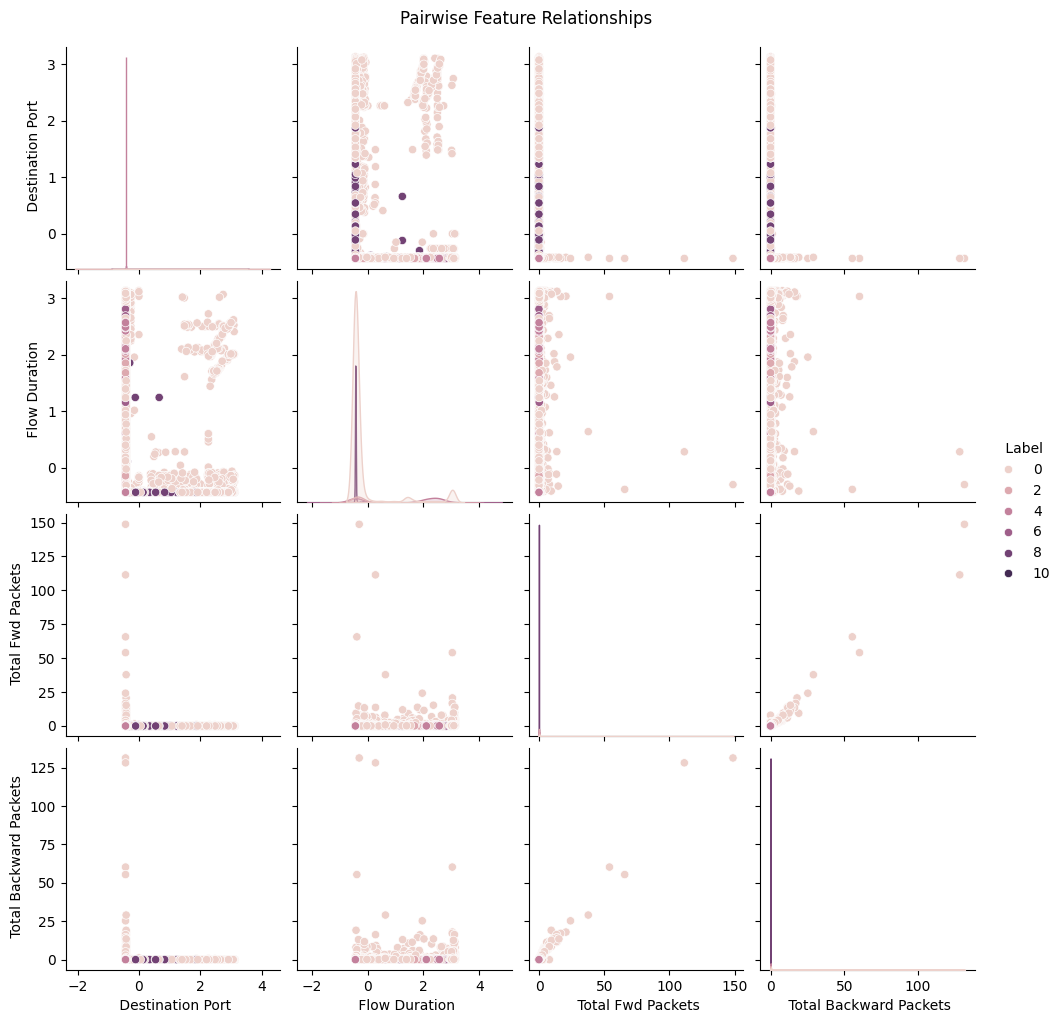

In [188]:
sample_features = list(numeric_cols[:4])  # visualize only a few to keep plots readable and time reasonable
plot_features = sample_features + [target_col]
sns.pairplot(df[plot_features], hue=target_col, diag_kind="kde")
plt.suptitle("Pairwise Feature Relationships", y=1.02)
plt.show()

# 2. Model Training, Comparison, and Ensemble 

### Create train and test datasets

In [189]:
from sklearn.model_selection import train_test_split
X = df.drop(columns=[target_col])
y = df[target_col]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Training set size:", X_train.shape)
print("Test set size:", X_test.shape)

Training set size: (40000, 71)
Test set size: (10000, 71)


### Logistic regression

c:\Users\arthu\OneDrive\Efrei\I1\S5\MachineLearning\machineLearningCybersecurity\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\arthu\OneDrive\Efrei\I1\S5\MachineLearning\machineLearningCybersecurity\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()

Confusion matrix:  [[8015    0    7    0   19    2    1    7   15    2    0    0]
 [   7    0    0    0    0    0    0    0    2    0    0    0]
 [  16    0  426    0    0    0    0    0    0    0    0    0]
 [   2    0    0   22    0    0    0    0    0    0    0    0]
 [   6    0    3    1  803    0    0    0    0    0    0    0]
 [   4    0    0    0    0   14    1    0    0    0    0    0]
 [   1    0    0    0    0    0   17    1    0    0    0    0]
 [  18    0    0    0    0    0    0   19    0    0    0    0]
 [   2    0    0    0    0    0    0    0  541    0    0    0]
 [  17    0    0    0    0    0    0    0    0    0    0    0]
 [   5    0    0    0    0    0    0    0    0    0    0    0]
 [   4    0    0    0    0    0    0    0    0    0    0    0]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      8068
           1       0.00      0.00      0.00         9
           2       0.98      0.96      0.97       442
       

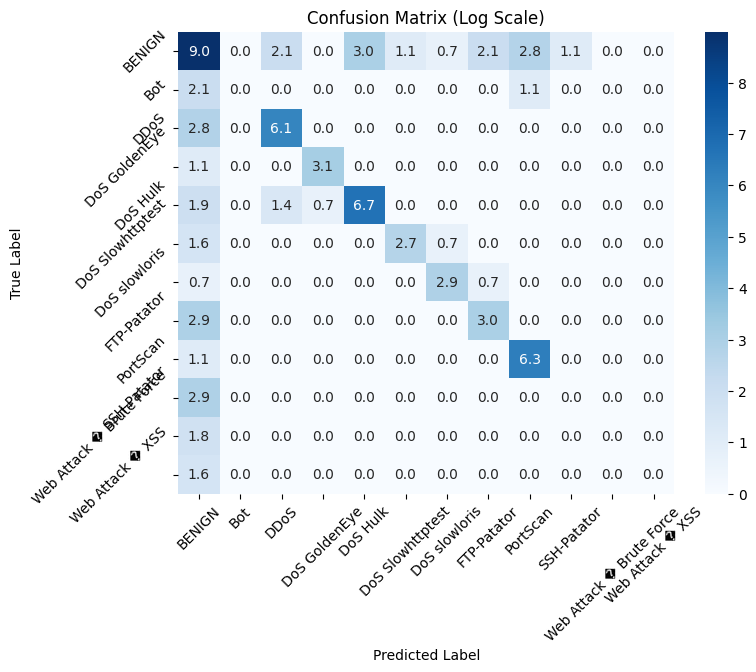

In [190]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(X_train, y_train)

### Evaluate the model
from sklearn.metrics import classification_report, confusion_matrix
y_pred = model.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion matrix: ", conf_matrix)
print(classification_report(y_test, y_pred))

plt.figure(figsize=(8, 6))
# Use log scale for better visualization when one class is very frequent
conf_matrix_log = np.log1p(conf_matrix)  # log(1 + x) to handle zeros
sns.heatmap(conf_matrix_log, annot=True, fmt='.1f', cmap='Blues')
plt.title("Confusion Matrix (Log Scale)")
plt.xlabel("Predicted Label")
plt.xticks(ticks=np.arange(len(class_names))+0.5, labels=class_names, rotation=45)
plt.ylabel("True Label")
plt.yticks(ticks=np.arange(len(class_names))+0.5, labels=class_names, rotation=45)
plt.show()

A lot of attacks are not detected by logistic regression, especially minority classes. The model tends to predict the majority class "Benign" too often. Still, we get decent f1-scores for some classes like DDoS and DoS Hulk.

## 3.2 KNN implementation :

In [195]:
neigh = KNeighborsClassifier(n_neighbors=5, weights='distance')
neigh.fit(X_res, y_res)
y_pred = neigh.predict(X_test)
print(classification_report(y_test, y_pred))
y_pred_train = neigh.predict(X_res)
print(classification_report(y_res, y_pred_train))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00      8068
           1       0.37      0.78      0.50         9
           2       1.00      1.00      1.00       442
           3       0.80      1.00      0.89        24
           4       0.98      1.00      0.99       813
           5       0.95      1.00      0.97        19
           6       0.82      0.95      0.88        19
           7       0.90      1.00      0.95        37
           8       0.99      1.00      1.00       543
           9       0.80      0.94      0.86        17
          10       0.33      0.60      0.43         5
          11       1.00      0.25      0.40         4

    accuracy                           0.99     10000
   macro avg       0.83      0.88      0.82     10000
weighted avg       1.00      0.99      0.99     10000

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28087
           1       1.00 

## 2.3 SVM classification

In [ ]:
param_grid = {
    'C': [0.1, 1, 10, 100],        # Paramètre de régularisation
    'gamma': [0.01, 0.1, 1, 10],   # Paramètre du noyau RBF
    'kernel': ['rbf']              # Utiliser le noyau RBF
}
svm = SVC(kernel='rbf', class_weight='balanced')

# Recherche sur grille pour trouver les meilleurs paramètres
grid_search = GridSearchCV(svm, param_grid, cv=5)
grid_search.fit(X_res, y_res)

best_svm = grid_search.best_estimator
y_pred = best_svm.predict(X_test)
print(classification_report(y_test, y_pred))

# 3. Evaluation Metrics and Analysis

# 4. Interpretability and Explainability

# 5. Docker Deployment 

# 6. MLflow Tracking 